In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as A
import pandas as pd
from sklearn.manifold import TSNE
import sklearn.manifold 
from matplotlib import pyplot as plt
import re
from numpy  import array
from scipy import stats
from scipy.spatial import distance

In [4]:
corpus_filename = '../data/extracted_emoji_sequences.txt' 

In [5]:
corpus = open(corpus_filename).read().splitlines()

In [4]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

In [5]:
def onlyEmojiSequences(tokens):
    threshold_emojis = [x for x in tokens if len(x) > 1]
    return threshold_emojis

In [6]:
tokenized_corpus = tokenize_corpus(corpus)
emojiSequences = onlyEmojiSequences(tokenized_corpus)

In [7]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

# this is just the very basic translation both ways plus the length of vocabulary

In [8]:
window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

# sole purpose of this is to have pairs! of target and context word
# super simple once you have figured out the code!

In [9]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

# this is a one hot encoded something

In [10]:
dtype = torch.float 
dimensionSize = 300
num_epochs = 25
learning_rate = 0.001


firstLayer = torch.randn(dimensionSize, vocabulary_size, requires_grad=True).float()
secondLayer = torch.randn(vocabulary_size, dimensionSize, requires_grad=True).float()

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:


        # one hot encoded tensor
        x = get_input_layer(data).float()
        # target word 
        y_true = torch.from_numpy(np.array([target])).long()

        # Hidden Layer: gradient magic happening ...
        z1 = torch.matmul(firstLayer, x)
        z2 = torch.matmul(secondLayer, z1)

        # introducing non-linearity
        softmax = A.LogSoftmax(dim=0)
        soft_max_output = softmax(z2)

        # neg_log_likelihood
        loss = F.nll_loss(soft_max_output.view(1,-1), y_true)
        loss_val += loss  # this might be to please the  framework, and adding stuff to the gradient calculator
        
        # propagating it back
        loss.backward()
        
        # updating the weights of both layers
        firstLayer.data -= learning_rate * firstLayer.grad.data
        secondLayer.data -= learning_rate * secondLayer.grad.data

        # set the gradients to zero for next iteration
        firstLayer.grad.data.zero_()
        secondLayer.grad.data.zero_()
        
    # this keeps track of the loss, hopefully it does converge
#     if epo % 1000 == 0:    
#         print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

    print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')





Loss at epo 0: 13.036076545715332
Loss at epo 1: 6.882392406463623
Loss at epo 2: 5.676666259765625
Loss at epo 3: 5.081389904022217
Loss at epo 4: 4.710700035095215
Loss at epo 5: 4.456678867340088
Loss at epo 6: 4.26845645904541
Loss at epo 7: 4.122274398803711
Loss at epo 8: 4.005948543548584
Loss at epo 9: 3.9109647274017334
Loss at epo 10: 3.8308568000793457
Loss at epo 11: 3.7632195949554443
Loss at epo 12: 3.705390214920044
Loss at epo 13: 3.6553702354431152
Loss at epo 14: 3.611668348312378
Loss at epo 15: 3.5733392238616943
Loss at epo 16: 3.539370059967041
Loss at epo 17: 3.5090274810791016
Loss at epo 18: 3.4817843437194824
Loss at epo 19: 3.4571220874786377
Loss at epo 20: 3.4346909523010254
Loss at epo 21: 3.4143643379211426
Loss at epo 22: 3.3956871032714844
Loss at epo 23: 3.378598928451538
Loss at epo 24: 3.3628556728363037


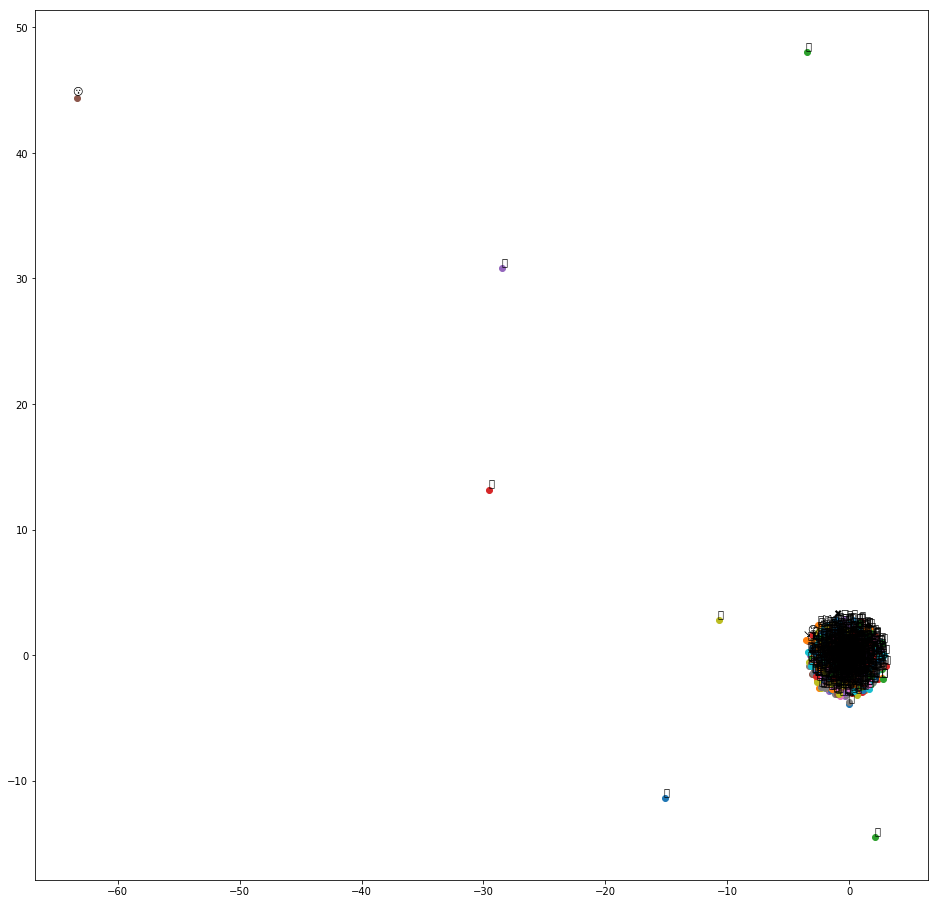

In [11]:
"Creates and TSNE model and plots it"
tokens = []

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

new_values = tsne_model.fit_transform(secondLayer.detach().numpy())

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(vocabulary[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

In [12]:
for x in range(len(word2idx)):
    word2idx[('U+{:X}'.format(ord(idx2word[x])))] = word2idx.pop(idx2word[x])

In [13]:
corpus_filename = './data/EmoSim508.json'
corpus = open(corpus_filename).read()

In [14]:
myEmojiPairScores = []
approved_annotator_results = []
all_annotator_results = list(array(re.findall('(?<=_Annotator_Agreement": )(.*?)(?=\})', corpus)))

# get all unicodes from all 508 pairs
unicodeEmojiPairs = re.findall('(?<=unicodeshort": ")(.*?)(?=\")', corpus)

for x in range(508):
    emoji1 = unicodeEmojiPairs.pop()
    emoji2 = unicodeEmojiPairs.pop()
    respective_annotator_result = all_annotator_results.pop(0)
    if (emoji1 and emoji2 in word2idx) and ((len(emoji1) < 9 ) and (len(emoji2) < 9)):
        try:
            myEmojiPairScores.append(distance.euclidean(secondLayer.detach().numpy()[word2idx[emoji1]], secondLayer.detach().numpy()[word2idx[emoji2]]))
            approved_annotator_results.append(respective_annotator_result)
        except:
            print("didn't work")
    

didn't work


In [15]:
print(stats.spearmanr(myEmojiPairScores, approved_annotator_results))

SpearmanrResult(correlation=0.2655620509498753, pvalue=2.2712144887075923e-09)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
